## Diabetes First Impressions

Conduct brief supervised learning analysis on data set found on Kaggle [here](https://www.kaggle.com/uciml/pima-indians-diabetes-database), fitting logistic regression and gradient tree boosting models. Additional feature resampling and feature engineering are explored as well. Spring 2020 returning member assignment for NYU Stern's Business Analytics Club.

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sys import path as sys_path
from textwrap import fill
from time import time
%matplotlib inline
sns.set(style = "darkgrid")

I use methods from a package I wrote myself called `shizuka`. Development will most likely be halted until the summer due to school.

In [3]:
# import shizuka modules: first add to sys.path if need be
_shizuka_dir = "C:\\Users\\D\\START\\prog_proj\\shizuka"
if _shizuka_dir in sys_path: pass
else:
    sys_path.append(_shizuka_dir)
    print("appended _shizuka_dir to module search path")
# shizuka imports
from shizuka.plotting import coef_plot, multiclass_stats
from shizuka.model_selection import resampled_cv

### Reading the data

We first read the data and pose our standard supervised learning question. Given feature matrix $ \mathbf{X} $, with categorical response $ y \in \{0, \, 1\} $ given by some unknown $ f : \mathcal{X} \rightarrow \{0, \, 1\} $, can we learn a function $ \hat{f} \in \mathcal{H} $ approximating $ f $, where $ \mathcal{H} $ is a hypothesis set of functions, that minimizes classification error?

First we preview data and look at the shape of the data. Not a lot of observations that we can use.

In [94]:
raw_data = pd.read_csv("./data/diabetes.csv")
print("{0}\n\nshape: {1}".format(raw_data.dtypes, raw_data.shape))
raw_data.head()

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


I don't like the format of the feature labels, so for aesthetic purposes, I will set them all to lowercase with separating underscores.

In [95]:
# rename columns (aesthetic)
fcols = ["pregnancies", "glucose", "blood_pressure", "skin_thickness", "insulin", "bmi", 
         "diabetes_pedigree_function", "age"]
rcol = "outcome"
raw_data.columns = fcols + [rcol]
raw_data.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Feature exploration

As usual, we first start with feature exploration. Let's do a pairplot to see both pairwise feature correlations and distributions by class type.

**Remark.** This will take a few seconds to run since there are lots of graphs being generated all at once.  
**Remark.** `outcome` is also plotted since it is numeric. If we used string labels it would not be plotted.

c:\users\d\start\python3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
c:\users\d\start\python3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


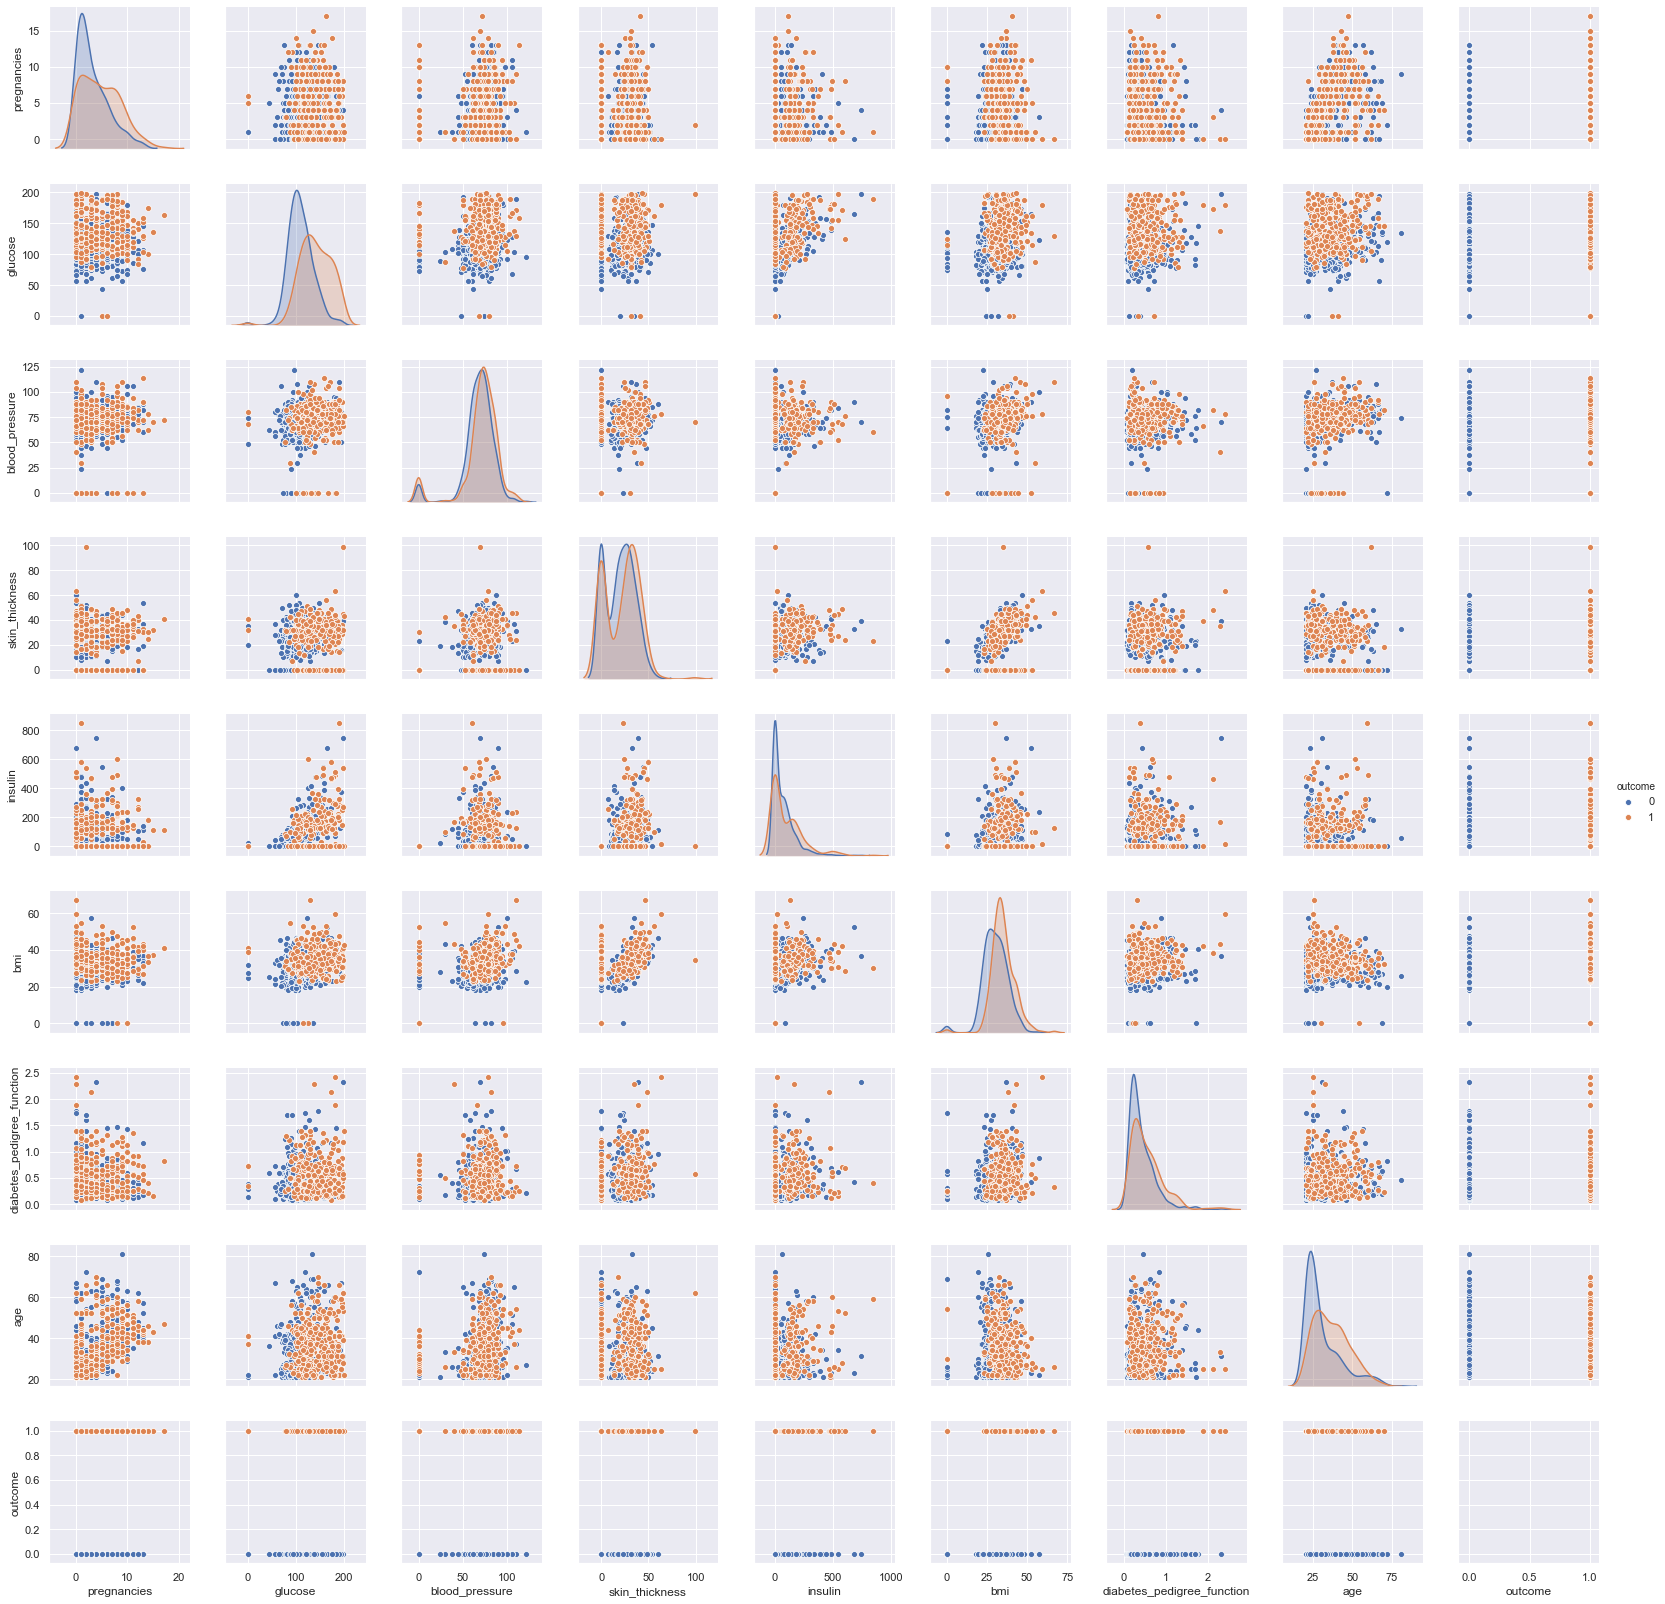

In [101]:
# error is probably due to 0 division since i included the outcome column
sns.pairplot(raw_data, hue = "outcome")

Most of the pairwise feature correlations are not significant, which is good. Some feature pairs, like `skin_thickness` and `bmi`, have some moderate correlation, but let's just ignore that for now. Also, there aren't really any features that individually indicate clear class distinctions. We do see that for some features like `skin_thickness` and `blood_pressure`, the distributions for both classes are almost identical, while for features such as `diabetes_pedigree_function` and `insulin`, the distributions are similar except for the density under the peaks. Other features like `age`, `glucose`, and `pregnancies`, have clear class differences in the shape of the sample distribution, but still are overlapping. 

Let's also compute the correlations of our continuous features just to quantify our observations. Most correlations are low.

In [70]:
raw_data[fcols].corr()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age
pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341
glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514
blood_pressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528
skin_thickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970
insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163
bmi,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242
diabetes_pedigree_function,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561
age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000


We can qualitatively assess how the features differ by class. Using `age` as an example, it is pretty clear that on average, older people tend to get diabetes, while those without diabetes are predominantly young people. `bmi` also shows that those with diabetes seem to have similar distributions for BMI, but shifted upwards more. `glucose` also shows that those with diabetes have higher levels of glucose in their blood on average as well.

Looking at histograms of each feature, without making class distinctions, we have the following figure.

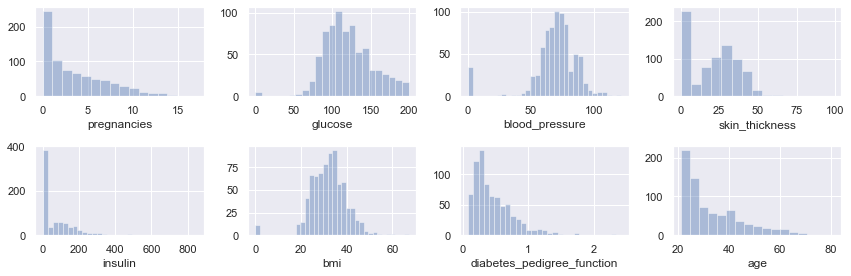

In [92]:
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (12, 4))
# flatten for ease of iterating
axs = np.ravel(axs)
for ft, ax in zip(fcols, axs): sns.distplot(raw_data[ft], kde = False, ax = ax)
# adjustment
fig.tight_layout()

Looking at these histograms and looking at the data preview [here](https://www.kaggle.com/uciml/pima-indians-diabetes-database) on Kaggle, we can draw a few conclusions about general data features. First, as expected, `pregnancies` is right-skewed, as generally females don't get pregnant too many times. `age` and `insulin` are also right-skewed, as it appears that this sample if mostly drawn from the younger population, while usually insulin levels are not too high, save for some outliers. `diabetes_pedigree_function` is also right-skewed, as the posterior likelihood for diabetes is usually lower, as those with diabetes are a minority class. `bmi` is right-skewed but mostly symmetric, although there is a troubling peak near 0 which may be due to some outliers or data recording errors. `blood_pressure` has a similar issue. `skin_thickness` appears to be strongly bimodal, which is interesting.

We also quickly plot the class frequencies; as expected, there are many more examples of Pima females without diabetes.

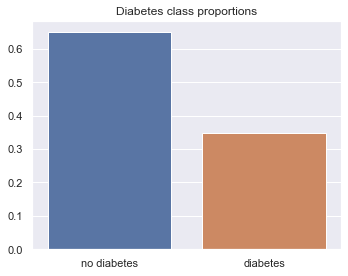

In [168]:
# count number of diabetic individuals
ndb = sum(raw_data["outcome"])
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 4))
sns.barplot(data = pd.DataFrame([[1 - ndb / len(raw_data), ndb / len(raw_data)]], 
                                columns = ["no diabetes", "diabetes"]), ax = ax)
ax.set_title("Diabetes class proportions")
fig.tight_layout()
fig.savefig("./figures/diabetes_classes.png")

### Data preprocessing

The problem with the data set is that a lot of our features are have values in $ \mathbb{N} \cup \{0\} $, which is vague with regards to whether or not the feature should be treated as continuous or categorical*. It is obvious that `BMI` and `DiabetesPedigreeFunction` are continuous variables, as they take values in $ \mathbb{R}_{\ge 0} $. The question is how to treat the remaining integer-valued features; it is therefore a question of discretion. For simplicity, we will first treat all the features as continuous, and later on consider engineering a few multi-level categorical features from some of the features.

We first preprocess our data as usual, standardizing to produce two feature matrices `X` and `Xs`, where `Xs` has standardized continuous features.

\***Remark**. I ignore the notebook instructions on how to treat each feature, as I engineer diferent categorical features later on.

In [97]:
# rename columns (aesthetic)
fcols = ["pregnancies", "glucose", "blood_pressure", "skin_thickness", "insulin", "bmi", 
         "diabetes_pedigree_function", "age"]
rcol = "outcome"
raw_data.columns = fcols + [rcol]
## create scaled and unscaled features (unscaled better for online learning)
y = pd.DataFrame(raw_data.iloc[:, -1])
# standardize features (which we all treat as continuous for now)
X = pd.DataFrame(raw_data.iloc[:, 0:-1])
scl = StandardScaler(copy = True)
Xs = pd.DataFrame(scl.fit_transform(X), columns = fcols)
# look at scaled continuous data
Xs.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496


We will perform a standard 80-20 training and test split, with `random_state = 7` to keep the split consistent. Cross-validation is 5 folds.

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)
Xs_train, Xs_test = train_test_split(Xs, test_size = 0.2, random_state = 7)

Let's also save our data in case our notebook crashes, as it would suck to have to re-run all the cells again.

In [141]:
X_train.to_csv("./data/X_train.csv", index = False)
X_test.to_csv("./data/X_test.csv", index = False)
Xs_train.to_csv("./data/Xs_train.csv", index = False)
Xs_test.to_csv("./data/Xs_test.csv", index = False)
y_train.to_csv("./data/y_train.csv", index = False)
y_test.to_csv("./data/y_test.csv", index = False)

### Logistic regression: `X_train`

We fit a standard logistic regression model and choose strength of $ L^2 $-regularization with grid search. Cross-validation used in grid search is 5-fold, and we choose accuracy as our scoring metric. After choosing our regularization constant, we will then proceed to eliminate features using `RFECV`.

In [109]:
lgr = LogisticRegression(penalty = "l2", solver = "lbfgs", n_jobs = 2)
# C is inverse of regularization strength (scales non-regularized part of loss function)
lgr_params = {"C": [1, 10, 50, 100]}
lgr_gscv = GridSearchCV(lgr, lgr_params, scoring = "accuracy", n_jobs = 2, cv = 5, verbose = 1)
# need to use scaled values (although lbfgs is robust to scaling?)
lgr_gscv.fit(Xs_train, y_train)
# show best estimator
lgr_best = lgr_gscv.best_estimator_
lgr_best

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.2s finished
c:\users\d\start\python3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=2, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Looks like high regularization is preferred (`C = 1`). Let's check mean CV accuracy and the test accuracy of the best estimator, and a few statistics.

5-fold lgr cv accuracy:		0.78013
best lgr test accuracy:		0.78571
misclassification rate for 0:	0.08247
misclassification rate for 1:	0.43860
best lgr test precision:	0.80000
best lgr test AUC:		0.73946
best lgr test recall:		0.56140


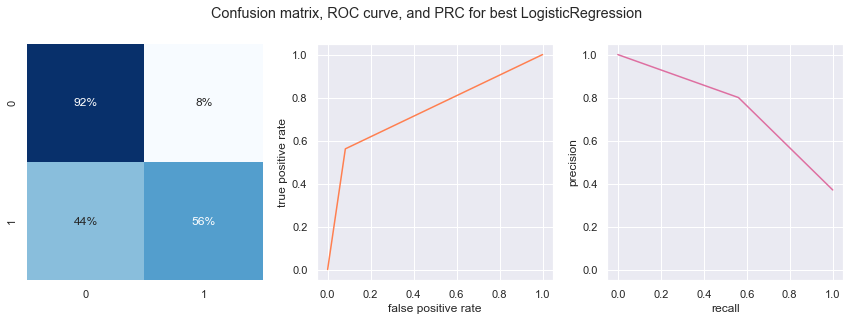

In [54]:
# note: the two accuracies are actually different if you go past 5 decimal places
print("5-fold lgr cv accuracy:\t\t{0:.5f}\nbest lgr test accuracy:\t\t{1:.5f}"
      "".format(np.mean(lgr_gscv.cv_results_["mean_test_score"]), lgr_best.score(Xs_test, y_test)))
# create figure and save; return figure, confusion matrix, and statistics
fig, cmat, stats_dict = multiclass_stats(lgr_best, Xs_test, y_test, best_model = True,
                                         norm_true = True, outfile = "./figures/lgr_gscv_stats.png")
# misclassification rates
print("misclassification rate for 0:\t{0:.5f}\nmisclassification rate for 1:\t{1:.5f}"
      "".format(*stats_dict["mc_rates"]))
# metrics
print("best lgr test precision:\t{0:.5f}\nbest lgr test AUC:\t\t{1:.5f}\n"
      "best lgr test recall:\t\t{2:.5f}"
      "".format(stats_dict["precision"], stats_dict["auc"], stats_dict["recall"]))

We see that the misclassification rate for the 1 class is significantly higher than for the 0 class, as expected due to the class imbalance. Our ROC and precision-recall curves are nothing impressive either, although we do note that the model does have a low false positive rate, hence the decent precision. The recall for the model is terrible however, as confirmed by our misclassification rates and our confusion matrix.

Now we take a look at our model coefficients, using `coef_plot` from `shizuka.plotting`.

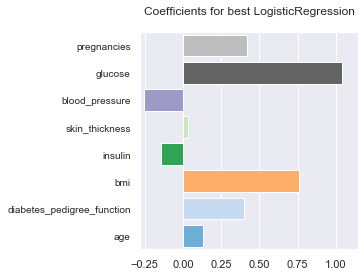

In [8]:
fig, ax = coef_plot(lgr_best, Xs_test.columns, best_model = True, outfile = "./figures/lgr_best_coef.png")

Since we standardized all our coefficients, we can interpret the coefficients, and we see that as one would expect, `glucose` has a large magnitude. Other coefficients that are important are `bmi`, and interestingly, `pregnancies`. `diabetes_pedigree_function` is also somewhat important, and we see that `age` and `skin_thickness` have little importance. These results match our intuition, as high glucose levels are generally correlated with onset of diabetes, and so is obesity (as measured by BMI). Interestingly, having higher blood pressure seems to be inversely related to onset of diabetes.

We could try and fit a sparser model, but 8 features don't really pose an issue with dimensionality. More concerning is the high misclassification rate for the 1 class; since all of our features are continuous, we may want to think about rebalancing the class proportions. But let's first try a "better" model.

We save our logistic regression `GridSearchCV` results for further use.

In [7]:
with open("./models/lgr_gscv.pickle", "wb") as lgr_gscv_file:
    pickle.dump(lgr_gscv, lgr_gscv_file)

### Gradient boosting: `X_train`

We fit a significantly more complex model to our data, namely a tree-based gradient boosting model. The main advantages of  using a gradient boosted tree ensemble versus using AdaBoost is that using deviance as a loss function is more robust to noise than AdaBoost's exponential loss function, and the fact that gradients are quick to calculate. We perform an exhaustive cross-validated grid search over several parameters, namely learning (shrinkage) rate, number of boosting stages, and tree depth. Hastie, Tibshirani, and Friedman state that choosing `4 <= max_depth <= 8` is usually sufficient, but we will also include stumps to only allow first-order effects. Subsampling is usually set to 0.5, and would thus lead to a stochastic gradient boosting model, but I opt to forego it since our training set is quite small. We can also increase the number of boosting stages since gradient boosting is robust to overfitting.

**Remark.** The following cell takes around a minute or two to run with `n_jobs = 2` as boosting models are slow to build.

In [27]:
gbc = GradientBoostingClassifier(loss = "deviance", random_state = 5)
gbc_params = {"learning_rate": [0.05, 0.1, 0.2], "n_estimators": [400, 600, 800], 
              "subsample": [1], "max_depth": [1, 6, 8]}
gbc_gscv = GridSearchCV(gbc, gbc_params, scoring = "accuracy", n_jobs = 2, cv = 5, verbose = 1)
# no need to use scaled values since trees naturally handle mixed data
time_a = time()
gbc_gscv.fit(X_train, y_train)
time_b = time()
# print runtime and show best estimator
print("runtime (mins): {0:.5f}".format((time_b - time_a) / 60))
gbc_best = gbc_gscv.best_estimator_
gbc_best

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   47.5s
[Parallel(n_jobs=2)]: Done 135 out of 135 | elapsed:  1.7min finished
c:\users\d\start\python3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


runtime (mins): 1.67353


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=400,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=5, subsample=1, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

We see that our gradient boosting model prefers a lower learning rate (`learning_rate = 0.05`) with stumps and 400 estimators. The fact that stumps were chosen leads us to believe that there may not be many cross-interactions between the features, which matches our observation that most features have little to no correlation with each other. Let's take a look at our classification statistics, as given by `multiclass_stats`.

5-fold gbc cv accuracy:		0.73663
best gbc test accuracy:		0.81169
misclassification rate for 0:	0.10309
misclassification rate for 1:	0.33333
best gbc test precision:	0.79167
best gbc test AUC:		0.78179
best gbc test recall:		0.66667


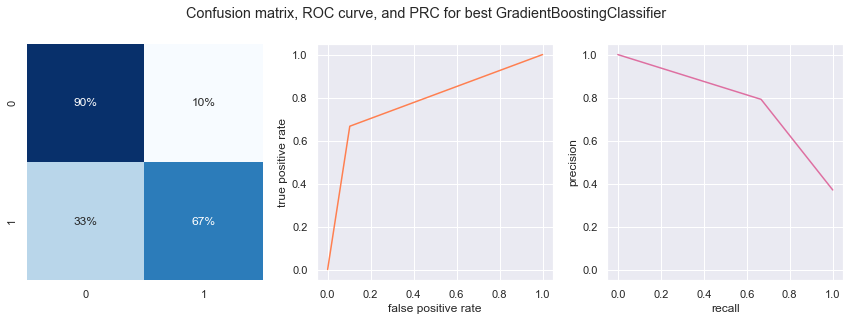

In [53]:
print("5-fold gbc cv accuracy:\t\t{0:.5f}\nbest gbc test accuracy:\t\t{1:.5f}"
      "".format(np.mean(gbc_gscv.cv_results_["mean_test_score"]), gbc_best.score(X_test, y_test)))
# create figure and save; return figure, confusion matrix, and statistics
fig, cmat, stats_dict = multiclass_stats(gbc_best, X_test, y_test, best_model = True,
                                         norm_true = True, outfile = "./figures/gbc_gscv_stats.png")
# misclassification rates
print("misclassification rate for 0:\t{0:.5f}\nmisclassification rate for 1:\t{1:.5f}"
      "".format(*stats_dict["mc_rates"]))
# some metrics
print("best gbc test precision:\t{0:.5f}\nbest gbc test AUC:\t\t{1:.5f}\n"
      "best gbc test recall:\t\t{2:.5f}"
      "".format(stats_dict["precision"], stats_dict["auc"], stats_dict["recall"]))

We see that the average cross-validation accuracy for the gradient boosting model is lower than for logistic regression, but the test accuracy of the best gradient boosting model edges out the logistic regression model. Misclassification rates for the 0 and 1 class balance out a bit; the gradient boosting model slightly misclassifies the 0 class by 2%, but reduces misclassification rate of the 1 class by 9%, which is a substantial improvement. We also see a noticeable improvement in AUC and recall as well, although of course our false negative rate is still quite high. So overall, the gradient boosting model is better than the logistic regression model "out of the box", but there is definitely much room for improvement.

Let's also take a look at our feature importances, as given by `coef_plot`.

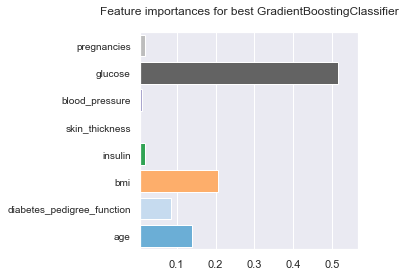

In [29]:
fig, ax = coef_plot(gbc_best, X_test.columns, best_model = True, outfile = "./figures/gbc_best_coef.png")

Looking at the feature importances, we again see that `glucose` is considered extremely important, followed by `bmi` and and `age`. The feature importances tell a slightly different story from the logistic regression coefficients, as although `glucose` is by and far the most important feature, `bmi` is considered more important for the gradient boosting model, along with `age`, while in the logistic regression model, `pregnancies` was more important.

Our performance is ok on not-transformed data, but we are still dogged by the class imbalance problem, so we need to resample. 

As before, we save our gradient boosting classifier `GridSearchCV` object results.

In [55]:
with open("./models/gbc_gscv.pickle", "wb") as gbc_gscv_file:
    pickle.dump(gbc_gscv, gbc_gscv_file)

### Class resampling

We use the well-known `SMOTE` implementation in `imblearn` for this task, as in my experience `SMOTEENN` tends to result in much more overfitting on training data, especially in the presence of label noise. However, one must be careful when performing resampling with cross-validation. The naive trap is to resample all of the training data, and then perform cross-validation on the resampled training data. This is invalid (as was pointed out to us by a mentor last semester) as doing this essentially modifies the generating joint distribution of the training data, so the model is validating parameter choices and training on a validation set with this modified conditional density. So I wrote my own simple function implementing resampled k-fold cross validated grid search which returns average cross-validation scores for each parameter combination as well as the best estimator.

**Remark.** I need to load all the relevant training and test data again since I ended up making different directories to save the results for this analysis. What was supposed to be a toy assignment for returning club members ended up with me going down the rabbit hole again since I have lots of time during break.

**Remark.** One can find pickled models in `./models`, all data files in `./data`, and figures in `./figures`.

In [35]:
raw_data = pd.read_csv("./data/diabetes.csv")
X_train, Xs_train = pd.read_csv("./data/X_train.csv"), pd.read_csv("./data/Xs_train.csv")
X_test, Xs_test = pd.read_csv("./data/X_test.csv"), pd.read_csv("./data/Xs_test.csv")
y_train, y_test = pd.read_csv("./data/y_train.csv"), pd.read_csv("./data/y_test.csv")

We use the method `resampled_cv` from `shizuka.model_selection` for this purpose, with 5-fold cross-validation, and use a gradient boosting model with stumps, no subsampling, 400 estimators, and with a learning rate of 0.05, the same parameters we used our previous gradient boosting model.

**Remark.** My implementation is not multiprocessing, so it is slow. One should also be aware that `imblearn` resamplers do not guarantee that passing an `n_jobs` value > 1 or -1 will result in usage of multiple cores. This method takes only a few seconds to run.

In [37]:
gbcr = GradientBoostingClassifier(loss = "deviance", random_state = 5, learning_rate = 0.05,
                                  n_estimators = 400, subsample = 1, max_depth = 1)
scv_results = resampled_cv(gbcr, X_train, y_train, resampler = "SMOTE", random_state = 1, cv = 5)

c:\users\d\start\python3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
c:\users\d\start\python3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
c:\users\d\start\python3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
c:\users\d\start\python3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24

We report the total runtime of the method, which is quite fast due to our low sample size, and check out our model parameters and CV scores.

In [47]:
gbcr_best = scv_results.best_estimator
print("runtime (seconds): {0:.5f}\n".format(scv_results.total_time))
print(fill(repr(scv_results.best_params), width = 80, subsequent_indent = " "))
print("\nbest gbcr cv score:\t{0:.5f}\nmean gbcr cv score:\t{1:.5f}"
      "".format(scv_results.best_cv_score, scv_results.mean_cv_score))

runtime (seconds): 3.14327

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate':
 0.05, 'loss': 'deviance', 'max_depth': 1, 'max_features': None,
 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split':
 None, 'min_samples_leaf': 1, 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'n_iter_no_change': None,
 'presort': 'deprecated', 'random_state': 5, 'subsample': 1, 'tol': 0.0001,
 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

best gbcr cv score:	0.79675
mean gbcr cv score:	0.75081


Looks like our mean cross-validation accuracy increased. Let's call `multiclass_stats` and see some other statistics to get a better picture.

best gbcr test accuracy:	0.77273
misclassification rate for 0:	0.20619
misclassification rate for 1:	0.26316
best gbc test precision:	0.67742
best gbc test AUC:		0.76533
best gbc test recall:		0.73684


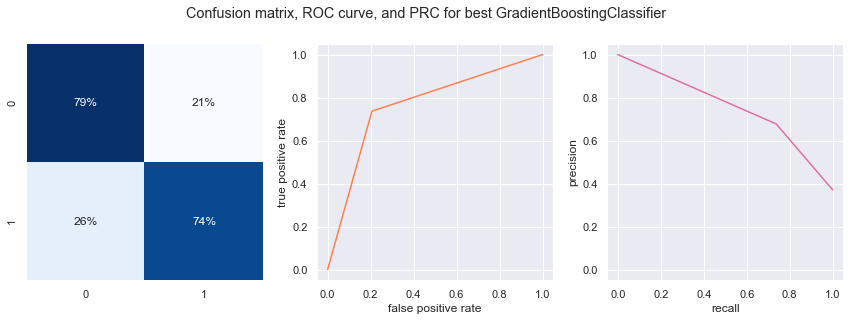

In [52]:
print("best gbcr test accuracy:\t{0:.5f}".format(gbcr_best.score(X_test, y_test)))
# create figure and save; return figure, confusion matrix, and statistics
fig, cmat, stats_dict = multiclass_stats(gbcr_best, X_test, y_test, best_model = True,
                                         norm_true = True, outfile = "./figures/gbcr_srcv_stats.png")
# misclassification rates
print("misclassification rate for 0:\t{0:.5f}\nmisclassification rate for 1:\t{1:.5f}"
      "".format(*stats_dict["mc_rates"]))
# some metrics
print("best gbc test precision:\t{0:.5f}\nbest gbc test AUC:\t\t{1:.5f}\n"
      "best gbc test recall:\t\t{2:.5f}"
      "".format(stats_dict["precision"], stats_dict["auc"], stats_dict["recall"]))

Our results are mixed. Our test accuracy has fallen below that of our logistic regression accuracy, but out resampling did its job, as our misclassification rates have been evened out, at the cost of both being relatively high. Our precision is fallen significantly, but our recall has risen, as confirmed by our confusion matrix. We do notice that our precision-recall curve has a steeper negative slope however, which is not desirable.

This not-so-great performance is not necessarily unexpected however, as we did not tune our model parameters with resampling. It may be that a different set of parameters is required for more optimal performance, but I did not yet implement a grid search type method in `shizuka`, so for brevity we omit this step.

Let's take a look at our feature importances with `coef_plot`, to compare with our previous gradient boosting model.

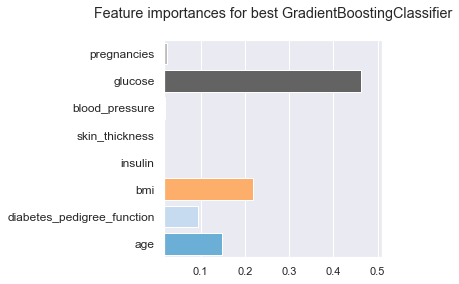

In [58]:
fig, ax = coef_plot(gbcr_best, X_test.columns, best_model = True, outfile = "./figures/gbcr_best_coef.png")

Our bar plot of feature importances is almost exactly the same as that produced by our previous gradient boosting model, except the tiny residual influences of `insulin` and `blood_pressure` have been reduced to zero. Again, as expected, `glucose` is the most important, followed by `bmi`, `age`, and to a lesser extent the `diabetes_pedigree_function`. Looking across the three models we have trained, it is evident that these four features are consistently considered important, especially `glucose` and `bmi`, results that match our intuition well.

We save our results from `resampled_cv` to its own pickle file in `./models`, and move to some feature engineering.

In [57]:
with open("./models/gbcr_srcv.pickle", "wb") as gbcr_srcv_file:
    pickle.dump(scv_results, gbcr_srcv_file)

### Feature engineering*

Here we approach one of the issues that we had brought up before earlier, which is that it is possible for us to engineer categorical variables that make sense from some of the inputs we had previously treated as continuous. For example, we could bucket `pregnancies` or `age` into different groups. By looking back at the pairplot and histogram that we created of our features, we can think of ways to define categorical variables in an attempt to maximize class separation.

We define our new features as such, looking at our pairplot and histogram to qualitatively determine a break point based on the class-conditional distributions in a way that we can hopefully maximize the class separation, even though class separation by any single feature is not clear-cut.

`age>=30` $ \triangleq \mathbb{1}_{\{\text{age} \ge 30\}} $, `bmi>=30` $ \triangleq \mathbb{1}_{\{\text{bmi} \ge 30\}} $, `glucose>=120` $ \triangleq \mathbb{1}_{\{\text{glucose} \ge 120\}} $, `pregnancies>=5` $ \triangleq \mathbb{1}_{\{\text{pregnancies} \ge 5\}} $

\***Remark.** More accurately, very simple feature engineering.

In [61]:
## create these new features and assign them to X_train, X_test. use lambdas and column names.
# starting column names for the features we will use
sources = ("age", "bmi", "glucose", "pregnancies")
# new feature column labels
new_labs = ("age>=30", "bmi>=30", "glucose>=120", "pregnancies>=5")
# lambda functions to define our new variables (note age and bmi have same lambda)
funcs = (lambda x: 1 if x >= 30 else 0, lambda x: 1 if x >= 30 else 0, 
         lambda x: 1 if x >= 120 else 0, lambda x: 1 if x >= 5 else 0)
# map lambdas and assign new columns to extended Xe_train, Xe_test
Xe_train, Xe_test = X_train.copy(), X_test.copy()
for col, new_lab, func in zip(sources, new_labs, funcs):
    Xe_train = Xe_train.assign(**{new_lab: tuple(map(func, Xe_train[col]))})
    Xe_test = Xe_test.assign(**{new_lab: tuple(map(func, Xe_test[col]))})
# show new shapes vs. old shapes
print("X_train, Xe_train shapes:\t{0}, {1}\nX_test, Xe_test shapes:\t\t{2}, {3}"
      "".format(X_train.shape, Xe_train.shape, X_test.shape, Xe_test.shape))
# preview Xe_train
Xe_train.head()

X_train, Xe_train shapes:	(614, 8), (614, 12)
X_test, Xe_test shapes:		(154, 8), (154, 12)


,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,age>=30,bmi>=30,glucose>=120,pregnancies>=5
0,5,108,72,43,75,36.1,0.263,33,1,1,0,1
1,2,102,86,36,120,45.5,0.127,23,0,1,0,0
2,4,158,78,0,0,32.9,0.803,31,1,1,1,0
3,3,112,74,30,0,31.6,0.197,25,0,1,0,0
4,1,122,64,32,156,35.1,0.692,30,1,1,1,0


Now we train another `GradientBoostingClassifer` on our extended feature matrix, using vanilla grid search and the same grid parameters. We use the same choice for `n_jobs`, `cv`, and again use accuracy as our scoring metric, and choose `random_state = 5` for reproducibility.


In [63]:
gbce = GradientBoostingClassifier(loss = "deviance", random_state = 5)
gbce_params = {"learning_rate": [0.05, 0.1, 0.2], "n_estimators": [400, 600, 800],
               "subsample": [1], "max_depth": [1, 6, 8]}
gbce_gscv = GridSearchCV(gbce, gbce_params, scoring = "accuracy", n_jobs = 2, cv = 5, verbose = 1)
time_a = time()
gbce_gscv.fit(Xe_train, y_train)
time_b = time()
# print runtime and show best estimator
print("runtime (mins): {0:.5f}".format((time_b - time_a) / 60))
gbce_best = gbce_gscv.best_estimator_
gbce_best

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   51.3s
[Parallel(n_jobs=2)]: Done 135 out of 135 | elapsed:  1.7min finished
c:\users\d\start\python3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


runtime (mins): 1.73737


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=400,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=5, subsample=1, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

As before, let's get CV and test accuracies and call `multiclass_stats` to check out some classification statistics.

5-fold gbce cv accuracy:	0.73681
best gbce test accuracy:	0.81169
misclassification rate for 0:	0.10309
misclassification rate for 1:	0.33333
best gbce test precision:	0.79167
best gbce test AUC:		0.78179
best gbce test recall:		0.66667


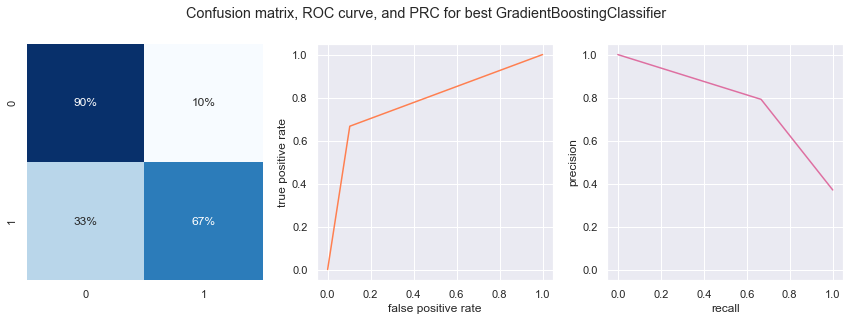

In [65]:
print("5-fold gbce cv accuracy:\t{0:.5f}\nbest gbce test accuracy:\t{1:.5f}"
      "".format(np.mean(gbce_gscv.cv_results_["mean_test_score"]), gbce_best.score(Xe_test, y_test)))
# create figure and save; return figure, confusion matrix, and statistics
fig, cmat, stats_dict = multiclass_stats(gbce_best, Xe_test, y_test, best_model = True,
                                         norm_true = True, outfile = "./figures/gbce_gscv_stats.png")
# misclassification rates
print("misclassification rate for 0:\t{0:.5f}\nmisclassification rate for 1:\t{1:.5f}"
      "".format(*stats_dict["mc_rates"]))
# some metrics
print("best gbce test precision:\t{0:.5f}\nbest gbce test AUC:\t\t{1:.5f}\n"
      "best gbce test recall:\t\t{2:.5f}"
      "".format(stats_dict["precision"], stats_dict["auc"], stats_dict["recall"]))

This looks just like the performance of the original stump-based, non-resampled gradient boosting model we built before. Even the statistics are the same! Let's call `coef_plot` to see what's going on by plotting our feature importances.

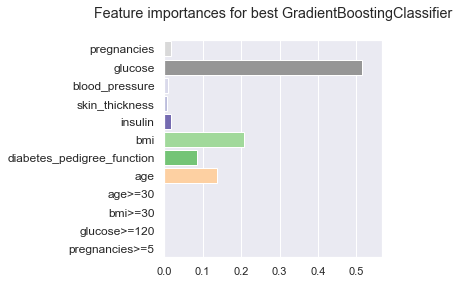

In [71]:
fig, ax = coef_plot(gbce_best, Xe_test.columns, best_model = True, outfile = "./figures/gbce_best_coef.png")

Our feature importances plot is essentially the same as that of the original gradient boosting model, as our four new features seem to provide zero additional predictive power. We could try other combinations of features, for example defining features like `age>=30_glucose>=120` $ \triangleq \mathbb{1}_{\{\text{age} \ge 30, \, \text{glucose} \ge 120\}} $.

However, since our gradient boosting models always seem to end up choosing stumps as estimators, it seems to imply that higher-order effects may not provide much extra predictive power. We will again omit this step to keep our analysis brief, and we pickle our model and new feature matrices.

In [72]:
Xe_train.to_csv("./data/Xe_train.csv", index = False)
Xe_test.to_csv("./data/Xe_test.csv", index = False)
with open("./models/gbce_gscv.pickle", "wb") as gbce_gscv_file:
    pickle.dump(gbce_gscv, gbce_gscv_file)

### Principal components analysis

As a short addendum to this analysis, we transform our standardized feature matrix `Xs` into principal components space, and then see how much variation in the data is explained by our components. There is no need to perform whitening since we have zero-mean, unit sample variance data in `Xs`. The PCA method and the support vector machine model are scaling sensitive anyways, so it is better to use our homogenously-scaled data.

**Remark.** Since our overall data set and number of components is small, full SVD solver is used.

**Remark.** Note we have to do PCA on the original `Xs` matrix, and then use `train_test_split(Xs, test_size = 0.2, random_state = 7)` to recover post-PCA `Xs_train` and `Xs_test` values. We need to place our results into DataFrames, using the same `RangeIndex` objects as used by `Xs_train` and `Xs_test`, as their original `Int64Index` is lost when written to .csv files using `to_csv` with `index = False`.

In [133]:
# perform PCA with svd solver, keeping all components
pca = PCA(svd_solver = "full")
Xr = pca.fit_transform(Xs)
# get new train/test, put into DataFrame using Xs_train.index and Xs_test.index
Xr_train, Xr_test = train_test_split(Xr, test_size = 0.2, random_state = 7)
pca_cols = ["pc_" + str(i + 1) for i in range(Xr.shape[1])]
Xr_train = pd.DataFrame(Xr_train, index = Xs_train.index, columns = pca_cols)
Xr_test = pd.DataFrame(Xr_test, index = Xs_test.index, columns = pca_cols)
# show shape of new PCA training data
Xr_train.head()

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8
0,0.601745,-0.284723,-1.085848,-0.232084,-0.916569,0.370393,0.218025,0.509302
1,0.910460,-1.263889,-1.987379,-0.679937,0.081467,0.492614,-0.173404,-0.375397
2,0.044833,0.663357,0.746611,0.579773,1.709134,0.001359,-0.683312,0.166631
3,-0.476918,-0.503015,-1.031214,-0.373198,-0.012140,0.018429,-0.051193,0.730789
4,0.717709,-1.240937,0.344975,0.254584,-0.039306,0.057355,0.394132,-0.118597


Let's see how much of the total variance is explained by each principal component.

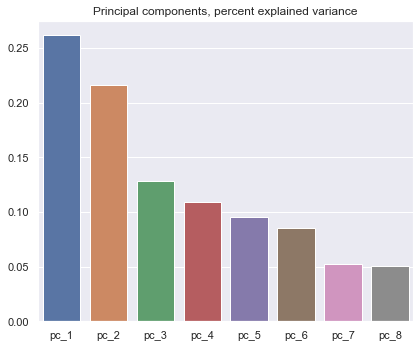

In [162]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
sns.barplot(data = pd.DataFrame([pca.explained_variance_ratio_], columns = pca_cols), 
            orient = "v", ax = ax)
ax.set_title("Principal components, percent explained variance")
fig.tight_layout()
fig.savefig("./figures/pca_variances.png")

We see that amount of variance explained by the principal components decreases smoothly across components; the first two components do not even explain half the total variance. Let's plot the first two principal components against each other to see how much class separation we can achieve.

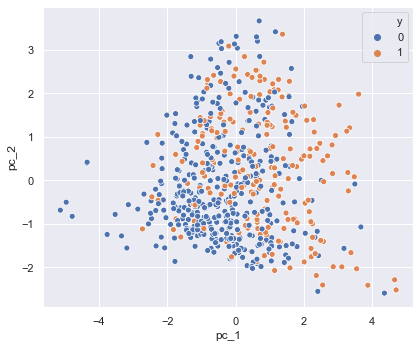

In [161]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
# attach y_train to first two columns of Xr_train
sns.scatterplot(x = "pc_1", y = "pc_2", data = Xr_train.iloc[:, :2]
                .assign(**{"y": y_train.iloc[:, 0]}), hue = "y", ax = ax)
fig.tight_layout()
fig.savefig("./figures/pca_plot.png")

Unfortunately, our class separation by the first two principal components is not too good, as expected. Most likely, if we were to fit a model on the principal components, we would have to include multiple components and perhaps do some feature elimination to get the full effect. 

We save our `PCA` object and PCA features for later, for some time in the future when we would like to do more analysis.

In [9]:
with open("./pca.pickle", "wb") as pca_file:
    pickle.dump(pca, pca_file)
Xr_train.to_csv("./data/Xr_train.csv", index = False)
Xr_test.to_csv("./data/Xr_test.csv", index = False)

### Conclusion

Overall, we saw some interesting performance from the models, and were able to glean useful insights about which features were the most predictive and which were not so predictive. For example, it was very clear that `glucose` level is singularly the most predictivec feature, followed by `bmi`, a finding that matches our intuition exactly. Model performance was again hit by the class imbalance; the false negative rate was very high, and so recall was low. Generally model precision was ok, but attempts to reduce the false negative rate through resampling led to increases in the false positive rate. 

Future analysis can be done by doing a grid search with resampling (needs to be implemented), trying another nonlinear model such as a support vector machine with a poly or rbf kernel, and more detailed feature engineering. This notebook, as the title suggests, is a first impression of the data set and mostly focused on pinpointing which features are considered predictive, combating class imbalances, and trying to create features to clarify class separations.

Overall best model: gradient boosted stumps on original training data